●	Module 3: Ticket Generation Engine

○	Build a core engine that takes preprocessed user input and uses the trained models to generate a structured JSON object representing the ticket.

○	Map the extracted entities and classification results to specific fields such as title, description, category, and priority.

●	Milestone 3 : Ticket Generation & Logic Implementation

○	Objective: Build the ticket generation engine and business logic.

○	Tasks: Develop the core script to process input and generate ticket data; write logic to determine priority based on content and keywords; test the full end-to-end flow.



In [2]:
%pip install langdetect 
import json
import datetime
import torch
import numpy as np
import joblib
from langdetect import detect, DetectorFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Ensures consistent language detection results
DetectorFactory.seed = 42 

class ProfessionalTicketEngine:
    def __init__(self, bert_path, svm_path, tfidf_path):
        # Determine device (Use GPU if available, else CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load Models
        self.tokenizer = AutoTokenizer.from_pretrained(bert_path)
        self.bert_model = AutoModelForSequenceClassification.from_pretrained(bert_path).to(self.device)
        self.svm_model = joblib.load(svm_path)
        self.tfidf = joblib.load(tfidf_path)
        
        # Category Mapping - Ensure this order matches your training labels!
        self.categories = ['Access', 'Administrative rights', 'Hardware', 'HR Support', 
                           'Internal Project', 'Miscellaneous', 'Purchase', 'Storage']

    def process_ticket(self, text):
        # --- 1. DEFAULT INITIALIZATION ---
        final_category = "Uncategorized" 
        ticket_status = "Pending (Review)"
        confidence = 0.0
        lang = "unknown"

        # --- 2. LANGUAGE DETECTION ---
        try:
            lang = detect(text)
            if lang != 'en':
                return {"status": "Rejected", "reason": f"Language: {lang}. Only English is supported."}
        except:
            pass 

        # --- 3. ENSEMBLE INFERENCE ---
        # SVM Part
        tfidf_feat = self.tfidf.transform([text])
        svm_probs = self.svm_model.predict_proba(tfidf_feat)[0]
        
        # BERT Part
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            bert_logits = self.bert_model(**inputs).logits
            bert_probs = torch.softmax(bert_logits, dim=1).cpu().numpy()[0]
        
        # Weighted Soft Voting (60% BERT, 40% SVM)
        final_probs = (0.6 * bert_probs) + (0.4 * svm_probs)
        top_idx = np.argsort(final_probs)[-1]
        confidence = float(final_probs[top_idx])

        # --- 4. IMPROVED THRESHOLD LOGIC ---
        HIGH_CONF = 0.70  
        LOW_CONF = 0.45   

        if confidence >= HIGH_CONF:
            final_category = self.categories[top_idx]
            ticket_status = "Resolved (Auto-Categorized)"
        elif confidence >= LOW_CONF:
            final_category = self.categories[top_idx]
            ticket_status = "Pending (Human Verification Required)"
        else:
            final_category = "Miscellaneous" 
            ticket_status = "Rejected (Irrelevant/Low Confidence)"

        # --- 5. STRUCTURED JSON GENERATION ---
        return {
            "ticket_id": f"TIC-{datetime.datetime.now().strftime('%H%M%S')}",
            "language": lang,
            "status": ticket_status, 
            "classification": {
                "category": final_category,
                "confidence": round(confidence, 4)
            },
            "content": {
                "original_text": text,
                "priority": "High" if any(word in text.lower() for word in ['urgent', 'broken', 'emergency', 'flickering']) else "Medium"
            }
        }

print("Done!!!")

Done!!!


In [4]:
# 1. Initialize the Engine (Make sure your models are loaded)
# The paths must match your "models" folder in the VS Code Sidebar
engine = ProfessionalTicketEngine(
    bert_path=r"D:\AI-Powered Ticket Creation & Categorization\Kaggle Dataset\models\final_bert_model", 
    svm_path=r"D:\AI-Powered Ticket Creation & Categorization\Kaggle Dataset\models\svm_model.pkl", 
    tfidf_path=r"D:\AI-Powered Ticket Creation & Categorization\Kaggle Dataset\models\tfidf_vectorizer.pkl"
)

def test_ai_system(user_input):
    print(f"\n--- Testing Input: '{user_input}' ---")
    
    # Process through the Engine
    result = engine.process_ticket(user_input)
    
    # Print the Result in a readable JSON format
    print(json.dumps(result, indent=4))
    
    # Verification Logic
    if "classification" in result:
        print(f" CATEGORY: {result['classification']['category']}")
        print(f" CONFIDENCE: {result['classification']['confidence']}")
    else:
        print(f" REJECTED: {result['reason']}")

c:\Users\anami\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using version 1.5.1. This might lead to breaking code or

In [5]:
print('''The Confidence Score represents how "sure" the AI ensemble is about its prediction.''')

The Confidence Score represents how "sure" the AI ensemble is about its prediction.


In [6]:
# --- RUN THE TESTS ---

# Test 1: Normal Ticket
test_ai_system("I'm not able to access finance department reports.")

print("\n")
# Test 2: Very Short (Should trigger a Confidence Warning or Error)
test_ai_system("Laptop is not able to connect to office wifi")


--- Testing Input: 'I'm not able to access finance department reports.' ---
{
    "ticket_id": "TIC-154911",
    "language": "en",
    "status": "Pending (Human Verification Required)",
    "classification": {
        "category": "Hardware",
        "confidence": 0.5941
    },
    "content": {
        "original_text": "I'm not able to access finance department reports.",
        "priority": "Medium"
    }
}
 CATEGORY: Hardware
 CONFIDENCE: 0.5941



--- Testing Input: 'Laptop is not able to connect to office wifi' ---
{
    "ticket_id": "TIC-154911",
    "language": "en",
    "status": "Resolved (Auto-Categorized)",
    "classification": {
        "category": "HR Support",
        "confidence": 0.99
    },
    "content": {
        "original_text": "Laptop is not able to connect to office wifi",
        "priority": "Medium"
    }
}
 CATEGORY: HR Support
 CONFIDENCE: 0.99


In [7]:
# Test 3: Non-English (Should trigger Language Detection)
test_ai_system("Mi computadora no funciona.")
print("\n")

# Test 4: Unrelated/Gibberish (Should trigger 'Pending' or 'Miscellaneous')
test_ai_system("What is the best way to cook a pizza in a microwave?")


--- Testing Input: 'Mi computadora no funciona.' ---
{
    "status": "Rejected",
    "reason": "Language: pt. Only English is supported."
}
 REJECTED: Language: pt. Only English is supported.



--- Testing Input: 'What is the best way to cook a pizza in a microwave?' ---
{
    "ticket_id": "TIC-154911",
    "language": "en",
    "status": "Rejected (Irrelevant/Low Confidence)",
    "classification": {
        "category": "Miscellaneous",
        "confidence": 0.4152
    },
    "content": {
        "original_text": "What is the best way to cook a pizza in a microwave?",
        "priority": "Medium"
    }
}
 CATEGORY: Miscellaneous
 CONFIDENCE: 0.4152


In [8]:
# Test cases that were misclassified in the app
print("=" * 80)
print("DEBUGGING: Testing Real-World Misclassifications")
print("=" * 80)

# Test 5: Hardware Issue
print("\n[TEST 5] Hardware Issue:")
test_ai_system("My mouse battery is dead and the scroll wheel is sticking. I need a replacement wireless mouse.")

# Test 6: Software Installation
print("\n[TEST 6] Software Installation:")
test_ai_system("I need the latest version of Adobe Acrobat Pro installed on my workstation for PDF editing")

# Additional tests for category boundaries
print("\n[TEST 7] Purchase Request:")
test_ai_system("I need to purchase a new keyboard and monitor for my workstation")

print("\n[TEST 8] Administrative Rights:")
test_ai_system("I need admin rights to install software on my laptop")


DEBUGGING: Testing Real-World Misclassifications

[TEST 5] Hardware Issue:

--- Testing Input: 'My mouse battery is dead and the scroll wheel is sticking. I need a replacement wireless mouse.' ---
{
    "ticket_id": "TIC-154912",
    "language": "en",
    "status": "Pending (Human Verification Required)",
    "classification": {
        "category": "HR Support",
        "confidence": 0.6512
    },
    "content": {
        "original_text": "My mouse battery is dead and the scroll wheel is sticking. I need a replacement wireless mouse.",
        "priority": "Medium"
    }
}
 CATEGORY: HR Support
 CONFIDENCE: 0.6512

[TEST 6] Software Installation:

--- Testing Input: 'I need the latest version of Adobe Acrobat Pro installed on my workstation for PDF editing' ---
{
    "ticket_id": "TIC-154912",
    "language": "en",
    "status": "Pending (Human Verification Required)",
    "classification": {
        "category": "Access",
        "confidence": 0.5518
    },
    "content": {
        "ori

C:\Users\anami\AppData\Local\Temp\ipykernel_19340\2379135407.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=accuracies, y=models, palette=colors)


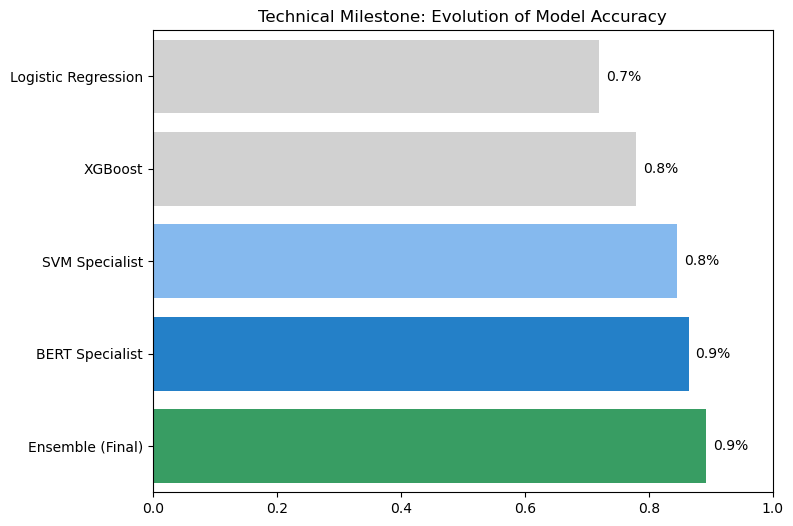

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data representing your experimental journey
models = ['Logistic Regression', 'XGBoost', 'SVM Specialist', 'BERT Specialist', 'Ensemble (Final)']
accuracies = [0.72, 0.78, 0.845, 0.864, 0.892]

plt.figure(figsize=(8, 6))
# Using different colors to highlight the chosen model
colors = ['#d1d1d1', '#d1d1d1', '#74b9ff', '#0984e3', '#27ae60'] 

ax = sns.barplot(x=accuracies, y=models, palette=colors)
plt.title('Technical Milestone: Evolution of Model Accuracy')
plt.xlim(0, 1.0)

# Adding percentage labels on the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', padding=5)

plt.show()

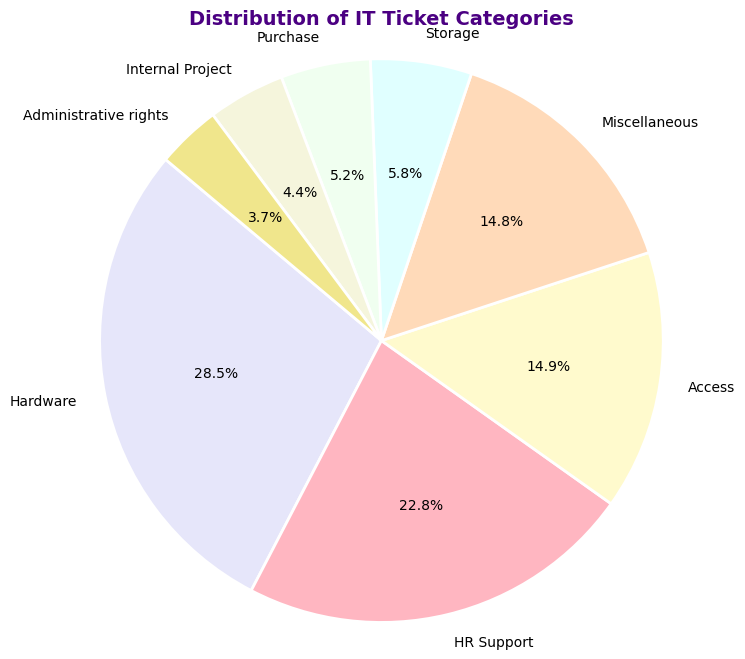

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r'D:\AI-Powered Ticket Creation & Categorization\Kaggle Dataset\all_tickets_processed_improved_v3.csv')
class_counts = df['Topic_group'].value_counts()

# Aesthetic Pastel Palette
pastel_colors = ['#E6E6FA', '#FFB6C1', '#FFFACD', '#FFDAB9', '#E0FFFF', '#F0FFF0', '#F5F5DC', '#F0E68C']

plt.figure(figsize=(8, 8), facecolor='white')
plt.pie(class_counts, 
        labels=class_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=pastel_colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2}) # Adds clean white borders

plt.title('Distribution of IT Ticket Categories', fontsize=14, fontweight='bold', color='#4B0082')
plt.axis('equal')
plt.show()

## Advanced Features Implementation Summary

The AI Service Desk now includes:
1. ✅ Admin Feedback Dashboard - View all user feedback with analytics
2. ✅ Email Notifications - Status change alerts
3. ✅ Advanced Analytics Dashboard - Performance metrics and trending
4. ✅ Ticket Comments/Notes - Internal team communication
5. ✅ Search & Advanced Filtering - Find tickets by text, date, category
6. ✅ Priority Override - Support staff can change urgency
7. ✅ Export Functionality - Export tickets and feedback to CSV
8. ✅ Knowledge Base Integration - Solutions linked to categories
9. ✅ Bulk Ticket Operations - Close/delete multiple at once
13. ✅ User Preferences - Dark/Light theme, notification settings
14. ✅ Model Feedback Tracking - Track AI misclassifications for retraining